<h1><center>Project Machine Learning - SYM</center></h1>
<h3><center>Michael Trushkin ( 323363838 ) and Maayan furer ( 209365634 ).</center></h3>
<h4><center><strong>Loading imports</strong></center></h4>

In [30]:
import importlib
import numpy as np
import game
importlib.reload(game)
from game import ColorableCliqueGame
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import gameEnvF
importlib.reload(gameEnvF)
from gameEnvF import draw, triangle_huristic, alphabetaMaxDepth, alphabetaMove, random_move, getPsuedoLegalStates, getLegalStatesAndTag
from gameEnvF import triangleP0_huristic, triangleSQR_huristic, distinct_cherry_counter, numpy_distinct_cherry_counter, indexToMove, moveToIndex
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier

models = {}

<h4><strong>Preview of game state</strong></h4>

<strong>Rules:</strong> </br>
There is a graph K6, that start blank all edges are white. </br>
each turn a player colors one edge in it own color. </br>
the player that creates a monochromatic triangle in its own color first loses.

<strong>Some Facts </strong></br>
In many games such as this there is the problem where the first player to move loses. </br>
and in this game its also the case, its possible to find a strategy such that the blue player, second player wins 100% of the times. </br>
we also notice in later stages that its considerably harder to win as red player, even when the red player can look "deeper" into the future. </br>
Maybe that just means that our huristic function is actually pretty good.

<strong>About the Vector:</strong> </br>
The Values 1-15, reprecent the color of the coresponding edge, first value is probably the color of (0<->1).</br>
The last value in the vector reprecent the next player to move.

Game state ( 0 ): [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
Game state ( 1 ): [ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  1]
Game state ( 2 ): [ 0  0  0  0  0 -1  0  0  0  0  0  1  0  0  0 -1]
Game state ( 3 ): [ 0  0  0  0  0 -1  0  0  0  0 -1  1  0  0  0  1]
Game state ( 4 ): [ 1  0  0  0  0 -1  0  0  0  0 -1  1  0  0  0 -1]
Game state ( 5 ): [ 1  0  0  0  0 -1 -1  0  0  0 -1  1  0  0  0  1]


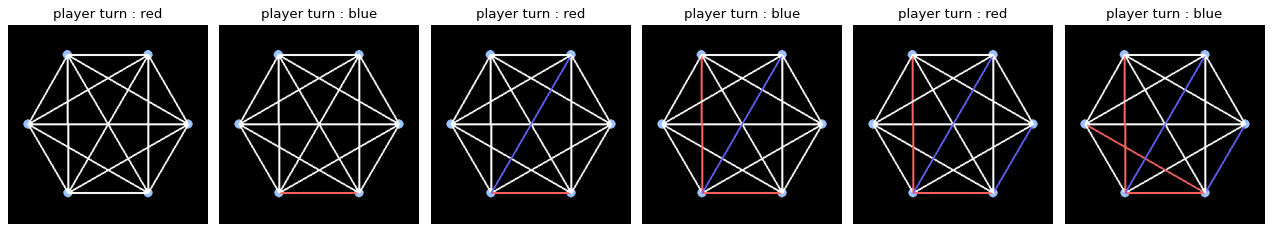

In [2]:
colors = [(255,100,100), (100,100,255)]
env = ColorableCliqueGame(300,300,6,colors)
figure(figsize=(16, 6), dpi=80)
moves = 6
for i in range(moves):
    plt.subplot(1,moves,i+1)
    axs = plt.gca()
    axs.set_axis_off()
    draw(env, False)
    print("Game state (", i ,"):" ,env.state1D())
    player = "red"
    if env.player == 1:
        player = "blue"
    axs.set_title("player turn : " + player)
    random_move(env)
env.undo()
plt.tight_layout()

<h4><strong>Loading the data</strong></h4>

As this game uses a K6, it has 15 distinct edge that each can be colored in 3 colors, white, blue or red.<br>
hence there are 3^15 possible game states, but from there there are a lot of unreachable states i.e, the possible states are where, <br>
the number of red edges to blue edges is equal or red has by 1 more (as red plays first).

For thus we made functions above that iterate over all possible legal states, then we made an aproximation function that yields, <br>
how "likely", red/blue to win, where value > 0, means that the huristic function thinks that red is more likely to win, and negative value means blue is more likely.

In [3]:
filename = 'data\K6D5m.npz'
with open(filename, 'rb') as f:
    a = np.load(f, allow_pickle=True)['data']

X : np.ndarray = a[:, 0]
Y : np.ndarray = a[:, 1]
Y = Y.astype(np.float32)
X = np.array(list(X))

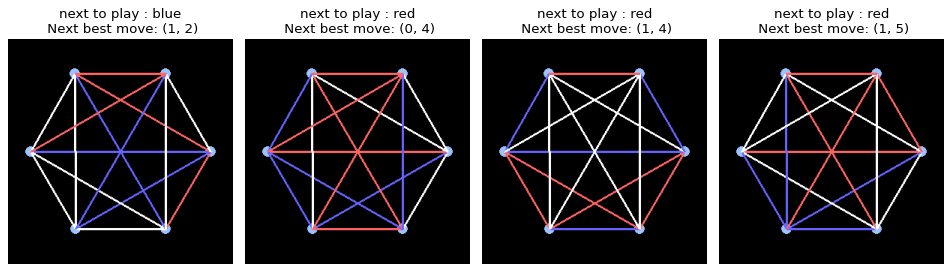

In [10]:
indexes = [45001, 60000, 250000, 170001]
figure(figsize=(12, 6), dpi=80)
i = 1
for index in indexes:
    plt.subplot(1,len(indexes),i)
    axs = plt.gca()
    axs.set_axis_off()
    player = "red"
    if X[index][-1] == -1:
        player = "blue"

    colors = [(255,100,100), (100,100,255)]
    env = ColorableCliqueGame(300,300,6, colors)
    env.loadfrom1D(X[index])
    draw(env, False)

    axs.set_title("next to play : " + player +"\n Next best move: " + str(indexToMove(Y[index])))
    i += 1
plt.tight_layout()

<h3><strong>Our Goal.</strong></h3>

The model would output for each possible move, now likely we should do it, and hopefully learn to pick the best possible next move. </br>
To make sure that happen the model would output a vector of size 15, where the index with the highest value would be picked as next move. </br>
Before that we would set to 0 all indices where the move is impossible to take.

<h4><strong>Creating test and train data.</strong></h4>
First Lets limit the Y values to be between -1 and 1.

In [17]:
Yn = Y
print(X.shape)
print("Min value:", Yn.min())
print("Max value:", Yn.max())
print("Mean value:", Yn.mean())
print("Variance:", Yn.var())

(1348431, 16)
Min value: 0.0
Max value: 14.0
Mean value: 4.4047666
Variance: 16.166708


Looks like out function for the next best move, prioritezes to make the "smallest" move possible in lexicographic order, with might be not that great. </br>
We can easily fix it by picking at random from all possible best moves, rather then the first best. </br>
The problem is that it would take a lot of time to regenerate the data so we will do with that.

In [42]:
biggest = 0
biggest_index = 0
for i in range(int(Yn.max() + 1)):
    acc = np.count_nonzero(Yn == i)
    print(indexToMove(i), "accurances :", acc)
    if acc > biggest:
        biggest = acc
        biggest_index = i
print("Dummy classifier score :", biggest / Yn.shape[0])

(0, 1) accurances : 234678
(0, 2) accurances : 188174
(0, 3) accurances : 153744
(0, 4) accurances : 127192
(0, 5) accurances : 106389
(1, 2) accurances : 89223
(1, 3) accurances : 76060
(1, 4) accurances : 65756
(1, 5) accurances : 57543
(2, 3) accurances : 51356
(2, 4) accurances : 46148
(2, 5) accurances : 42026
(3, 4) accurances : 38907
(3, 5) accurances : 36525
(4, 5) accurances : 34710
Dummy classifier score : 0.1740378261846546


<h4><strong>Creating test and train data.</strong></h4>

In [58]:
import warnings
warnings.filterwarnings('always') 
X_train,X_test,y_train,y_test =train_test_split(X,Yn , test_size=0.20, random_state=42,shuffle=True)

names = []
for i in range(15):
    names.append(str(indexToMove(i)))

def score_model(_model, X_test, y_test, model_name = "Model"):
    pred_test = _model.predict(X_test)

    acc = accuracy_score(y_test, np.round(pred_test)) * 100

    print("-------", model_name, "-------")
    print('Accuracy: {}%'.format(acc))
    print(metrics.classification_report(y_test, pred_test, digits=3, target_names=names))

<h4><strong>Running Logistic regression.</strong></h4>

In [59]:
log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)

score_model(log_reg, X_test, y_test, "Log reg")

------- Log reg -------
Accuracy: 17.3897889034325%


c:\Users\Michael\anaconda3\envs\chessAi\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Michael\anaconda3\envs\chessAi\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      (0, 1)      0.174     1.000     0.296     46898
      (0, 2)      0.000     0.000     0.000     37538
      (0, 3)      0.000     0.000     0.000     30693
      (0, 4)      0.000     0.000     0.000     25298
      (0, 5)      0.000     0.000     0.000     21632
      (1, 2)      0.000     0.000     0.000     17806
      (1, 3)      0.000     0.000     0.000     15144
      (1, 4)      0.000     0.000     0.000     13234
      (1, 5)      0.000     0.000     0.000     11579
      (2, 3)      0.000     0.000     0.000     10358
      (2, 4)      0.000     0.000     0.000      9197
      (2, 5)      0.000     0.000     0.000      8416
      (3, 4)      0.000     0.000     0.000      7636
      (3, 5)      0.000     0.000     0.000      7352
      (4, 5)      0.000     0.000     0.000      6906

    accuracy                          0.174    269687
   macro avg      0.012     0.067     0.020    269687
weighted avg      0.030   

c:\Users\Michael\anaconda3\envs\chessAi\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<h3>Logistic regression</h3>

Logistic regression is basically a dummy clussifier in this case, it just always predict class 0, as it has the most examples

<h4><strong> Add features </strong></h4>
We can add more features for instnace we can count the number of edges that each player cannot play next.

In [60]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
# The ColumnsSelector class inherits from the sklearn.base classes 
# (BaseEstimator, TransformerMixin). This makes it compatible with 
# scikit-learn’s Pipelines
class AddCherryCount(BaseEstimator, TransformerMixin):
    # initializer 
    def __init__(self):
        # save the features list internally in the class
        pass
        
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        Xn = np.apply_along_axis(numpy_distinct_cherry_counter, 1, X)
        Xn = np.concatenate((X, Xn), axis=1)
        # return the dataframe with the specified features
        return Xn

In [62]:
# This functions is quite expensive in time
test = AddCherryCount()
test.transform(X_train[::25])

array([[-1,  0, -1, ...,  1,  4,  2],
       [ 1,  0,  0, ...,  1,  2,  1],
       [ 0,  0, -1, ...,  1,  3,  3],
       ...,
       [ 1,  0,  0, ...,  1,  1,  1],
       [ 1, -1,  0, ...,  1,  3,  1],
       [-1,  0,  0, ...,  1,  2,  1]], dtype=int64)

In [64]:
pipe = Pipeline([('cherrys', AddCherryCount()), ('lreg', LogisticRegression())])
pipe.fit(X_train, y_train)

score_model(pipe, X_test, y_test, "LogCherry")

------- LogCherry -------
Accuracy: 17.373844493802075%


c:\Users\Michael\anaconda3\envs\chessAi\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Michael\anaconda3\envs\chessAi\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      (0, 1)      0.177     0.991     0.300     46898
      (0, 2)      0.058     0.009     0.015     37538
      (0, 3)      0.040     0.001     0.001     30693
      (0, 4)      0.020     0.000     0.000     25298
      (0, 5)      0.000     0.000     0.000     21632
      (1, 2)      0.093     0.002     0.004     17806
      (1, 3)      0.000     0.000     0.000     15144
      (1, 4)      0.000     0.000     0.000     13234
      (1, 5)      0.000     0.000     0.000     11579
      (2, 3)      0.000     0.000     0.000     10358
      (2, 4)      0.000     0.000     0.000      9197
      (2, 5)      0.000     0.000     0.000      8416
      (3, 4)      0.000     0.000     0.000      7636
      (3, 5)      0.000     0.000     0.000      7352
      (4, 5)      0.000     0.000     0.000      6906

    accuracy                          0.174    269687
   macro avg      0.026     0.067     0.021    269687
weighted avg      0.051   

c:\Users\Michael\anaconda3\envs\chessAi\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [65]:
models["logc"] = pipe

<h3>Observations</h3>

Adding the features made a tiny bit of improvement but overall logregression fails.

<h4><strong>Adaboost</strong></h4>

We use only fraction of the data as adaboost simply "crashes" when used on the full dataset

In [66]:
from sklearn.ensemble import AdaBoostClassifier
regr = AdaBoostClassifier(random_state=0, n_estimators=100)
regr.fit(X_train[::30], y_train[::30])

score_model(regr, X_test, y_test, "Adaboost")

------- Adaboost -------
Accuracy: 18.640127258636866%
              precision    recall  f1-score   support

      (0, 1)      0.460     0.205     0.284     46898
      (0, 2)      0.366     0.238     0.289     37538
      (0, 3)      0.300     0.202     0.242     30693
      (0, 4)      0.241     0.109     0.150     25298
      (0, 5)      0.209     0.236     0.221     21632
      (1, 2)      0.182     0.191     0.187     17806
      (1, 3)      0.166     0.180     0.173     15144
      (1, 4)      0.169     0.098     0.124     13234
      (1, 5)      0.108     0.072     0.086     11579
      (2, 3)      0.100     0.164     0.124     10358
      (2, 4)      0.118     0.163     0.137      9197
      (2, 5)      0.072     0.180     0.103      8416
      (3, 4)      0.085     0.222     0.123      7636
      (3, 5)      0.068     0.143     0.092      7352
      (4, 5)      0.062     0.277     0.101      6906

    accuracy                          0.186    269687
   macro avg      0.180  

In [157]:
models["ada"] = regr

Adaboost still bad, but at least better then the dummy classifier.

In [67]:
pipe = Pipeline([('cherrys', AddCherryCount()), ('scaler', StandardScaler()), ('Adaboost', AdaBoostClassifier(random_state=0, n_estimators=200))])
pipe.fit(X_train[::30], y_train[::30])

score_model(pipe, X_test, y_test, "Adaboost cherry")

models["pada"] = pipe

------- Adaboost cherry -------
Accuracy: 13.968786037146765%
              precision    recall  f1-score   support

      (0, 1)      0.399     0.074     0.125     46898
      (0, 2)      0.336     0.133     0.190     37538
      (0, 3)      0.252     0.015     0.029     30693
      (0, 4)      0.212     0.042     0.070     25298
      (0, 5)      0.207     0.180     0.192     21632
      (1, 2)      0.168     0.106     0.130     17806
      (1, 3)      0.127     0.052     0.074     15144
      (1, 4)      0.134     0.522     0.213     13234
      (1, 5)      0.119     0.298     0.170     11579
      (2, 3)      0.120     0.382     0.183     10358
      (2, 4)      0.095     0.079     0.086      9197
      (2, 5)      0.086     0.102     0.093      8416
      (3, 4)      0.078     0.267     0.121      7636
      (3, 5)      0.076     0.274     0.120      7352
      (4, 5)      0.059     0.166     0.088      6906

    accuracy                          0.140    269687
   macro avg      

Somehow the added features only made things worse

<h4><strong>Decision tree.</strong></h4>
We expect a much better result with decision trees, as part of countring cherries is a lot of if/then statements.

<strong>Notice</strong></br>
As out dataset is quite big the kernel of python fails to run the fit function so we need to take fraction of the dataset, and not all of the dataset.

In [68]:
model = DecisionTreeClassifier()
model.fit(X_train[::30],y_train[::30])

score_model(model, X_test, y_test, "Decision Tree")

------- Decision Tree -------
Accuracy: 40.971941547052694%
              precision    recall  f1-score   support

      (0, 1)      0.629     0.589     0.608     46898
      (0, 2)      0.588     0.568     0.578     37538
      (0, 3)      0.554     0.519     0.536     30693
      (0, 4)      0.487     0.480     0.483     25298
      (0, 5)      0.368     0.366     0.367     21632
      (1, 2)      0.365     0.373     0.369     17806
      (1, 3)      0.309     0.319     0.314     15144
      (1, 4)      0.259     0.270     0.264     13234
      (1, 5)      0.184     0.200     0.192     11579
      (2, 3)      0.203     0.208     0.206     10358
      (2, 4)      0.173     0.188     0.180      9197
      (2, 5)      0.147     0.161     0.154      8416
      (3, 4)      0.135     0.148     0.141      7636
      (3, 5)      0.114     0.125     0.119      7352
      (4, 5)      0.115     0.130     0.122      6906

    accuracy                          0.410    269687
   macro avg      0.

In [69]:
models["dtree"] = model

<h3>Observations</h3>
Decision tree actually decision trees performed much better with is kinda understandable.</br>
One would expect that a human player would look at with edges would result in him losing and not picking those.

<strong>Adding cherries:</strong></br>

In [71]:
pipe = Pipeline([('cherrys', AddCherryCount()), ('scaler', StandardScaler()), ('Decision Tree', DecisionTreeClassifier())])
pipe.fit(X_train[::30], y_train[::30])

score_model(pipe, X_test, y_test, "Decision Tree Cherry")

models["pdtree"] = pipe

------- Decision Tree Cherry -------
Accuracy: 40.25221831233986%
              precision    recall  f1-score   support

      (0, 1)      0.625     0.590     0.607     46898
      (0, 2)      0.586     0.559     0.572     37538
      (0, 3)      0.547     0.519     0.532     30693
      (0, 4)      0.479     0.468     0.474     25298
      (0, 5)      0.356     0.356     0.356     21632
      (1, 2)      0.357     0.361     0.359     17806
      (1, 3)      0.295     0.306     0.300     15144
      (1, 4)      0.253     0.267     0.259     13234
      (1, 5)      0.187     0.196     0.191     11579
      (2, 3)      0.194     0.201     0.197     10358
      (2, 4)      0.153     0.166     0.159      9197
      (2, 5)      0.129     0.144     0.136      8416
      (3, 4)      0.124     0.144     0.133      7636
      (3, 5)      0.105     0.106     0.105      7352
      (4, 5)      0.110     0.125     0.117      6906

    accuracy                          0.403    269687
   macro avg  

Adding cherries does not seems to benefit us at all. 
That's to be expected as why should we really care?

<h4><strong> Random Forest </strong></h4>
Random forest is a model that just utalizes a lot of decisions trees, its similar to adaboost but where each model is in fact a decision tree.</br>
Hence its the Ideal candidate for our next model.</br>
For the same reason we cant train the RandomForest on all the data at once so we will add estimators to the decision tree and fit it in chunks

In [75]:
rf = RandomForestClassifier(n_estimators=10, warm_start=True, n_jobs=-1)
skip = 29
for i in range(skip):
    rf.fit(X_train[i::skip], y_train[i::skip])
    rf.n_estimators += 10

In [76]:
score_model(rf, X_test, y_test, "Random Forest")

models["rf"] = rf

------- Random Forest -------
Accuracy: 62.018562259211606%
              precision    recall  f1-score   support

      (0, 1)      0.594     0.948     0.730     46898
      (0, 2)      0.602     0.878     0.714     37538
      (0, 3)      0.610     0.809     0.695     30693
      (0, 4)      0.616     0.737     0.671     25298
      (0, 5)      0.643     0.645     0.644     21632
      (1, 2)      0.655     0.560     0.604     17806
      (1, 3)      0.668     0.465     0.548     15144
      (1, 4)      0.684     0.380     0.489     13234
      (1, 5)      0.709     0.286     0.408     11579
      (2, 3)      0.699     0.243     0.361     10358
      (2, 4)      0.725     0.187     0.297      9197
      (2, 5)      0.742     0.131     0.222      8416
      (3, 4)      0.766     0.103     0.182      7636
      (3, 5)      0.814     0.077     0.140      7352
      (4, 5)      0.815     0.059     0.110      6906

    accuracy                          0.620    269687
   macro avg      0.

<h3>Observations</h3>
Random forest is actually on the good side. </br>
Recall that our data is not really uniformly destributed, and there is no real "reason" to pick class 0 over say class 1, at some instances.

<strong>Adding cherries</strong>

In [78]:
rfp = RandomForestClassifier(n_estimators=10, warm_start=True, n_jobs=-1)
pipe = Pipeline([('cherrys', AddCherryCount()), ('scaler', StandardScaler()), ('Random forest', rfp)])
skip = 29
for i in range(skip):
    pipe.fit(X_train[i::skip], y_train[i::skip])
    rfp.n_estimators += 10

In [79]:
score_model(pipe, X_test, y_test, "Random Forest")

models["prf"] = pipe

------- Random Forest -------
Accuracy: 61.904726590454864%
              precision    recall  f1-score   support

      (0, 1)      0.589     0.958     0.729     46898
      (0, 2)      0.598     0.880     0.712     37538
      (0, 3)      0.607     0.807     0.693     30693
      (0, 4)      0.620     0.736     0.673     25298
      (0, 5)      0.651     0.643     0.647     21632
      (1, 2)      0.657     0.554     0.601     17806
      (1, 3)      0.676     0.463     0.550     15144
      (1, 4)      0.688     0.366     0.478     13234
      (1, 5)      0.713     0.278     0.400     11579
      (2, 3)      0.715     0.236     0.355     10358
      (2, 4)      0.733     0.181     0.290      9197
      (2, 5)      0.765     0.125     0.215      8416
      (3, 4)      0.782     0.097     0.172      7636
      (3, 5)      0.851     0.071     0.132      7352
      (4, 5)      0.857     0.052     0.098      6906

    accuracy                          0.619    269687
   macro avg      0.

<strong>Observations</strong></br>
As we can see we got even better results then before.


<h4><strong>KNN</strong></h4>
The issue with KNN is due to the sheer size of the data, it takes a very long time to make a prediction.

In [81]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=11)
model.fit(X_train, y_train)

score_model(model, X_test[::100], y_test[::100], "KNN")

models["knn"] = model

------- KNN -------
Accuracy: 60.88246199480905%
              precision    recall  f1-score   support

      (0, 1)      0.600     0.887     0.716       478
      (0, 2)      0.587     0.810     0.681       363
      (0, 3)      0.598     0.732     0.658       280
      (0, 4)      0.598     0.668     0.631       247
      (0, 5)      0.603     0.614     0.608       215
      (1, 2)      0.694     0.528     0.600       193
      (1, 3)      0.583     0.450     0.508       140
      (1, 4)      0.670     0.415     0.513       142
      (1, 5)      0.622     0.390     0.479       118
      (2, 3)      0.683     0.390     0.497       105
      (2, 4)      0.564     0.247     0.344        89
      (2, 5)      0.634     0.283     0.391        92
      (3, 4)      0.455     0.208     0.286        72
      (3, 5)      0.771     0.325     0.458        83
      (4, 5)      0.808     0.263     0.396        80

    accuracy                          0.609      2697
   macro avg      0.631     0.4

In [82]:
pipe = Pipeline([('cherrys', AddCherryCount()), ('scaler', StandardScaler()), ('KNN', KNeighborsClassifier(n_neighbors=11))])
pipe.fit(X_train, y_train)

score_model(pipe, X_test[::500], y_test[::500], "KNN")

models["pknn"] = pipe

------- KNN -------
Accuracy: 73.33333333333333%
              precision    recall  f1-score   support

      (0, 1)      0.750     0.944     0.836       108
      (0, 2)      0.690     0.817     0.748        71
      (0, 3)      0.706     0.873     0.780        55
      (0, 4)      0.707     0.674     0.690        43
      (0, 5)      0.617     0.674     0.644        43
      (1, 2)      0.864     0.594     0.704        32
      (1, 3)      0.733     0.846     0.786        26
      (1, 4)      0.737     0.424     0.538        33
      (1, 5)      0.800     0.516     0.627        31
      (2, 3)      0.833     0.577     0.682        26
      (2, 4)      0.867     0.619     0.722        21
      (2, 5)      0.688     0.688     0.688        16
      (3, 4)      0.833     0.500     0.625        10
      (3, 5)      0.889     0.533     0.667        15
      (4, 5)      0.778     0.700     0.737        10

    accuracy                          0.733       540
   macro avg      0.766     0.6

In [87]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(20, 30, 20), random_state=1, max_iter=2500)

clf.fit(X_train, y_train)

c:\Users\Michael\anaconda3\envs\chessAi\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(alpha=1e-05, hidden_layer_sizes=(20, 30, 20), max_iter=2500,
              random_state=1, solver='lbfgs')

In [219]:
score_model(clf, X_test, y_test, "NN")

------- NN -------
Accuracy: 59.66249763614857%
              precision    recall  f1-score   support

      (0, 1)      0.648     0.846     0.734     46898
      (0, 2)      0.634     0.790     0.704     37538
      (0, 3)      0.619     0.742     0.675     30693
      (0, 4)      0.606     0.703     0.651     25298
      (0, 5)      0.597     0.659     0.627     21632
      (1, 2)      0.568     0.597     0.582     17806
      (1, 3)      0.558     0.544     0.551     15144
      (1, 4)      0.538     0.491     0.514     13234
      (1, 5)      0.514     0.431     0.469     11579
      (2, 3)      0.518     0.419     0.463     10358
      (2, 4)      0.317     0.130     0.184      9197
      (2, 5)      0.210     0.039     0.066      8416
      (3, 4)      0.199     0.040     0.066      7636
      (3, 5)      0.212     0.025     0.045      7352
      (4, 5)      0.152     0.006     0.012      6906

    accuracy                          0.597    269687
   macro avg      0.459     0.43

In [220]:
score_model(clf, X_train, y_train, "NN")

------- NN -------
Accuracy: 59.70499024791794%
              precision    recall  f1-score   support

      (0, 1)      0.649     0.847     0.735    187780
      (0, 2)      0.636     0.792     0.705    150636
      (0, 3)      0.624     0.743     0.678    123051
      (0, 4)      0.607     0.701     0.651    101894
      (0, 5)      0.591     0.657     0.622     84757
      (1, 2)      0.571     0.599     0.584     71417
      (1, 3)      0.560     0.548     0.554     60916
      (1, 4)      0.535     0.487     0.510     52522
      (1, 5)      0.506     0.429     0.464     45964
      (2, 3)      0.514     0.423     0.464     40998
      (2, 4)      0.317     0.132     0.187     36951
      (2, 5)      0.239     0.045     0.076     33610
      (3, 4)      0.183     0.034     0.057     31271
      (3, 5)      0.200     0.024     0.043     29173
      (4, 5)      0.142     0.007     0.013     27804

    accuracy                          0.597   1078744
   macro avg      0.458     0.43

In [90]:
models["NN"] = clf

In [223]:
from sklearn.neural_network import MLPClassifier

clf2 = MLPClassifier(solver='lbfgs', alpha=1e-4,
                    hidden_layer_sizes=(50, 40, 30, 20, 10), random_state=1, max_iter=200)

clf2.fit(X_train, y_train)

In [175]:
def predicted_move(model, x):
    pred = model.predict_proba([x])
    bad = x[:-1] != 0
    pred[0][bad] = -1
    return np.argmax(pred)


index = 10251
pred = int(clf.predict(X[index:index+1])[0])

for i in range(X.shape[0]):
    pid = int(clf.predict(X[i:i+1])[0])
    if X[i][pid] != 0:
        index = i
        pred = pid
        break

print("initial",pred)
print(X[index][pred])
print(X[index])

print("fixed",predicted_move(clf, X[index]))

initial 13
-1
[-1  1 -1  1  1  1  0  1 -1  0  0 -1  0 -1 -1  1]
fixed 9


<h4><strong> Observations </strong></h4>
KNN doing as well and even better than Random Forest, We assume that somehow KNN manages to break the observations into maybe "triangles", </br>

<h2><strong> Testing models vs models </strong></h2>
<ul>
  <li>We will make a few tests, first we can play model vs random agent.</li>
  <li>then we can set models vs models</li>
  <li>lastly we can use models vs huristics (with MinMax).</li>
</ul>

In [200]:
def FuncVsFunc(game : ColorableCliqueGame, player1DecisionFunc, player2DecisionFunc):
    while game.winner == -1:
        if game.player == 0:
            player1DecisionFunc(game)
        else:
            player2DecisionFunc(game)

def tests(num, player1, name1, player2, name2, random_moves):
    p1wins = 0
    p2wins = 0
    print("------", name1 , 'vs', name2, "------")
    for _ in range(num):
        env = ColorableCliqueGame(300,300,6,colors)
        for __ in range(random_moves):
            random_move(env)
        FuncVsFunc(env, player1, player2)
        if env.winner == 0:
            p1wins += 1
        else:
            p2wins += 1
    print("red-player", name1, "| blue-player", name2)
    print("red-player won", p1wins, "| blue-player won", p2wins)
    p1wins = 0
    p2wins = 0
    for _ in range(num):
        env = ColorableCliqueGame(300,300,6,colors)
        for __ in range(random_moves):
            random_move(env)
        FuncVsFunc(env, player2, player1)
        if env.winner == 0:
            p1wins += 1
        else:
            p2wins += 1
    print("red-player", name2, "| blue-player", name1)
    print("red-player won", p1wins, "| blue-player won", p2wins)
    print()

In [201]:
def modelMove(model):
    return lambda game : game.applyMove(indexToMove(predicted_move(model, game.state1D())))

def linreg(game):
    modelMove(log_reg)(game)

def plinreg(game):
    modelMove(models["logc"])(game)

def huristic(game):
    alphabetaMove(game, 0, triangle_huristic)

print("saved models : ",list(models.keys()),"\n")

tests(100, random_move, "random-model", linreg, "Logistic Reg", 2)
tests(100, random_move, "random-model", plinreg, "Cherry Logistic reg", 2)
tests(100, huristic, "huristic", plinreg, "Cherry Linear reg", 2)

saved models :  ['logc', 'pada', 'dtree', 'pdtree', 'rf', 'prf', 'knn', 'pknn', 'NN', 'ada'] 

------ random-model vs Logistic Reg ------
red-player random-model | blue-player Logistic Reg
red-player won 48 | blue-player won 52
red-player Logistic Reg | blue-player random-model
red-player won 23 | blue-player won 77

------ random-model vs Cherry Logistic reg ------
red-player random-model | blue-player Cherry Logistic reg
red-player won 47 | blue-player won 53
red-player Cherry Logistic reg | blue-player random-model
red-player won 29 | blue-player won 71

------ huristic vs Cherry Linear reg ------
red-player huristic | blue-player Cherry Linear reg
red-player won 100 | blue-player won 0
red-player Cherry Linear reg | blue-player huristic
red-player won 0 | blue-player won 100



As expeced the LogReg model is a dummy classifier always picking the lowest move possible,
so its performing as bad as a random classifier.

In [202]:
env = ColorableCliqueGame(300,300,6,colors)

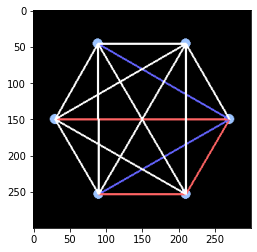

In [207]:
modelMove(models["rf"])(env)
#modelMove(models["dtree"])(env)
draw(env)

In [209]:
def ptree(game):
    modelMove(models["dtree"])(game)

def mtree(game):
    modelMove(models["pdtree"])(game)

tests(100, huristic, "huristic", mtree, "Decision Tree", 2)
tests(100, huristic, "huristic", ptree, "Decision Tree", 2)

------ huristic vs Decision Tree ------
red-player huristic | blue-player Decision Tree
red-player won 98 | blue-player won 2
red-player Decision Tree | blue-player huristic
red-player won 0 | blue-player won 100

------ huristic vs Decision Tree ------
red-player huristic | blue-player Decision Tree
red-player won 91 | blue-player won 9
red-player Decision Tree | blue-player huristic
red-player won 2 | blue-player won 98



Decision tree, with 40% accuracity somehow manages to win (sometimes) against our simple agent.

In [158]:
def forest(game):
    modelMove(models["rf"])(game)

def pforest(game):
    modelMove(models["prf"])(game)

tests(100, huristic, "huristic", forest, "Forest", 2)
tests(100, huristic, "huristic", pforest, "Cherry Forest", 2)

------ huristic vs Forest ------
red-player huristic | blue-player Forest
red-player won 83 | blue-player won 17
red-player Forest | blue-player huristic
red-player won 4 | blue-player won 96

------ huristic vs Cherry Forest ------
red-player huristic | blue-player Cherry Forest
red-player won 79 | blue-player won 21
red-player Cherry Forest | blue-player huristic
red-player won 8 | blue-player won 92



Random forest actually sometimes wins our simple deterministic huristic player

In [161]:
def madaboost(game):
    modelMove(models["ada"])(game)

def padaboost(game):
    modelMove(models["pada"])(game)

tests(100, huristic, "huristic", madaboost, "Adaboost", 2)
tests(100, huristic, "huristic", padaboost, "Cherry Adaboost", 2)

------ huristic vs Adaboost ------
red-player huristic | blue-player Adaboost
red-player won 100 | blue-player won 0
red-player Adaboost | blue-player huristic
red-player won 0 | blue-player won 100

------ huristic vs Cherry Adaboost ------
red-player huristic | blue-player Cherry Adaboost
red-player won 99 | blue-player won 1
red-player Cherry Adaboost | blue-player huristic
red-player won 2 | blue-player won 98



Just as the accuracity suggested Adaboost performs teribly.

<strong>Testing KNN model.</strong>

In [211]:
def mknn(game):
    modelMove(models["knn"])(game)

def pknn(game):
    modelMove(models["pknn"])(game)

tests(100, huristic, "huristic", mknn, "KNN", 2)
tests(100, huristic, "huristic", pknn, "Cherry KNN", 2)

------ huristic vs KNN ------
red-player huristic | blue-player KNN
red-player won 70 | blue-player won 30
red-player KNN | blue-player huristic
red-player won 6 | blue-player won 94

------ huristic vs Cherry KNN ------
red-player huristic | blue-player Cherry KNN
red-player won 60 | blue-player won 40
red-player Cherry KNN | blue-player huristic
red-player won 14 | blue-player won 86



In [217]:
def NNet(game):
    modelMove(models["NN"])(game)

def NNet2(game):
    modelMove(clf2)(game)


tests(100, huristic, "huristic", NNet, "Neural network", 2)
tests(100, huristic, "huristic", NNet2, "Neural network 2", 2)

------ huristic vs Neural network ------
red-player huristic | blue-player Neural network
red-player won 90 | blue-player won 10
red-player Neural network | blue-player huristic
red-player won 3 | blue-player won 97

------ huristic vs Neural network 2 ------
red-player huristic | blue-player Neural network 2
red-player won 98 | blue-player won 2
red-player Neural network 2 | blue-player huristic
red-player won 0 | blue-player won 100



<strong>Testing KNN model vs The real model</strong>

In [ ]:
tests(50, ptree, "Cherry forest", pknn, "Cherry KNN", 2)

------ Cherry linear vs Cherry KNN ------
red-player Cherry linear | blue-player Cherry KNN
red-player won 10 | blue-player won 40
red-player Cherry KNN | blue-player Cherry linear
red-player won 19 | blue-player won 31



<h2>Conclusion</h2>

We see that we succesfully learned the to predict a MinMax outcome of depth 3, Looks like this problem is harder then we initially tought. <br>
As even our huristic function fails to mostly win as Red player.

Still its evident that the model did learn something, our initial goal was to try use MinMax, on the model prediction to further improve it's performance, <br>
but as it stands the models actually work slower then using MinMax at bigger depth then the hurstics.

In The end the huristic function we are testing agains performs RedCherry - BlueCherry, and looks like Linear regression with chery features, <br>
might have actually learned something similar to that, as we see that it performs the best vs the cherry huristic.

<strong>Thanks for reading.</strong>